In [1]:
import pandas as pd
import numpy as np
import sys
import os
import warnings
warnings.filterwarnings('ignore')
path='C:\\Users\\11621842\\Desktop\\con_te'
sys.path.append(os.path.abspath(path))


In [2]:
age_gender_bkts=pd.read_csv(path + '\\airbnb_next_destination_data\\age_gender_bkts.csv')
countries=pd.read_csv(path + '\\airbnb_next_destination_data\\countries.csv')
sessions=pd.read_csv(path + '\\airbnb_next_destination_data\\sessions.csv')
train=pd.read_csv(path + '\\airbnb_next_destination_data/train_users.csv')
test=pd.read_csv(path + '\\airbnb_next_destination_data/test_users.csv')

 Data Exploration
    ### Age_Gender_Baskets

In [3]:
age_gender_bkts.shape

(420, 5)

In [4]:
age_gender_bkts.head(10)

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0
5,75-79,AU,male,298.0,2015.0
6,70-74,AU,male,415.0,2015.0
7,65-69,AU,male,574.0,2015.0
8,60-64,AU,male,636.0,2015.0
9,55-59,AU,male,714.0,2015.0


In [5]:
age_gender_bkts.year.unique()

array([2015.])

In [6]:
age_gender_bkts.groupby(['age_bucket', 'gender', 'country_destination'])['population_in_thousands'].sum().head(20)

age_bucket  gender  country_destination
0-4         female  AU                       781.0
                    CA                       991.0
                    DE                      1713.0
                    ES                      1198.0
                    FR                      1938.0
                    GB                      1888.0
                    IT                      1383.0
                    NL                       438.0
                    PT                       225.0
                    US                     10306.0
            male    AU                       824.0
                    CA                      1045.0
                    DE                      1811.0
                    ES                      1272.0
                    FR                      2035.0
                    GB                      1981.0
                    IT                      1468.0
                    NL                       462.0
                    PT                    

The Age/Gender Basket DataFrame contains interesting information about how many people in 2015 had tripped to each destination
for each gender and age_bucket combination.
I will use this table to extract the "prior probabilities" to travel to each destination for each customer, 
according to his age and gender.


    ### Sessions


In [7]:
sessions.shape

(10567737, 6)

In [8]:
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


The Session DataFrame contains 10567737 records. Each record is a specific session.
The sessions were made by 135484 distinct users.


In [9]:
# check nulls
sessions.isnull().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

In [10]:
# drop nul user_id
sessions = sessions[sessions['user_id'].isnull() == False]

In [11]:
# input Null secs_elapsed to zero
sessions.loc[sessions['secs_elapsed'].isnull(),'secs_elapsed']=0

In [12]:
# check nulls
sessions.isnull().sum()

user_id                0
action             79480
action_type      1122957
action_detail    1122957
device_type            0
secs_elapsed           0
dtype: int64

In [13]:
# let's expolore the variables
#action
sessions.action.value_counts()

show                           2758985
index                           841071
search_results                  723124
personalize                     704782
search                          533833
ajax_refresh_subtotal           486414
similar_listings                363423
update                          362708
social_connections              337764
reviews                         319318
active                          187370
similar_listings_v2             168457
lookup                          161422
create                          155233
dashboard                       152515
header_userpic                  141315
collections                     124067
edit                            108927
campaigns                       104647
track_page_view                  80949
unavailabilities                 77985
qt2                              64585
notifications                    59198
confirm_email                    58557
requested                        57020
identity                 


There are 212 actions with less then 1000 occurences, I'll replace them with 'OTHERS'


In [14]:
actions_to_rename=list(pd.DataFrame(sessions.action.value_counts())[pd.DataFrame(sessions.action.value_counts())['action']<1000].index)
sessions.loc[sessions['action'].isin(actions_to_rename), 'action'] = 'OTHERS'
sessions['action'] = sessions['action'].fillna('missing')

In [15]:
sessions.action.value_counts()

show                             2758985
index                             841071
search_results                    723124
personalize                       704782
search                            533833
ajax_refresh_subtotal             486414
similar_listings                  363423
update                            362708
social_connections                337764
reviews                           319318
active                            187370
similar_listings_v2               168457
lookup                            161422
create                            155233
dashboard                         152515
header_userpic                    141315
collections                       124067
edit                              108927
campaigns                         104647
track_page_view                    80949
missing                            79480
unavailabilities                   77985
qt2                                64585
notifications                      59198
confirm_email   

In [16]:
# action_type
sessions.action_type.value_counts()

view                3549375
data                2096655
click               1990058
-unknown-           1028251
submit               620063
message_post          86925
partner_callback      19053
booking_request       18762
modify                 1138
booking_response          4
Name: action_type, dtype: int64

In [17]:
sessions['action_type'] = sessions['action_type'].fillna('-unknown-')

In [18]:
# action_detail 
sessions.action_detail.value_counts()

view_search_results               1771026
p3                                1371626
-unknown-                         1028222
wishlist_content_update            704782
user_profile                       654626
change_trip_characteristics        486414
similar_listings                   363423
user_social_connections            335577
listing_reviews                    267991
update_listing                     267776
dashboard                          152515
user_wishlists                     152260
header_userpic                     141315
message_thread                     132199
edit_profile                       108531
message_post                        86925
contact_host                        80872
unavailable_dates                   77475
confirm_email_link                  58253
create_user                         54611
change_contact_host_dates           52426
user_profile_content_update         50353
user_reviews                        49424
p5                                

In [19]:
sessions['action_detail'] = sessions['action_detail'].fillna('-unknown-')
actions_detail_to_rename=list(pd.DataFrame(sessions.action_detail.value_counts())[pd.DataFrame(sessions.action_detail.value_counts())['action_detail']<1000].index)
sessions.loc[sessions['action_detail'].isin(actions_detail_to_rename), 'action_detail'] = 'OTHERS'

In [20]:
sessions.isnull().sum()

user_id          0
action           0
action_type      0
action_detail    0
device_type      0
secs_elapsed     0
dtype: int64



The Sessions Datafarme is composed by the users' sessions, the details of the actions, and their elapsed time.
I will use it to count the action made by each costumer, every different action_type made, and compute different time variable from elapsed_time



In [21]:
import customFunctions as f

In [22]:
### using my custom function to elaborate the session and age_gender_bskt DataFrames
sessions, age_gen_country = f.preparazione_Datasets(sessions=sessions, age_gender_bkts=age_gender_bkts)

### START WORKING ON SESSION DATAFRAME ###
### END SESSION DATAFRAME ###
### START WORKING ON AGE_GENDER_BKTS DATAFRAME ###
### END AGE_GENDER_BKTS DATAFRAME ###


In [23]:
print(sessions.shape)
sessions.head(10)

(135483, 23)


,user_id,secs_elapsed_sum,secs_elapsed_mean,secs_elapsed_min,secs_elapsed_max,secs_elapsed_median,secs_elapsed_std,secs_elapsed_var,day_pauses,long_pauses,...,booking_request,booking_response,click,data,message_post,modify,partner_callback,submit,view,action_count
0,00023iyk9l,867896.0,21697.400000,0.0,567165.0,843.0,91120.246977,8.302899e+09,2.0,1.0,...,1,0,4,9,1,0,1,0,21,40
1,0010k6l0om,586543.0,9310.206349,0.0,127898.0,847.0,22598.457942,5.106903e+08,2.0,0.0,...,0,0,16,9,0,0,1,0,17,63
2,001wyh0pz8,282965.0,3144.055556,0.0,50548.0,1104.0,6541.226692,4.278765e+07,0.0,0.0,...,0,0,66,2,0,0,0,3,8,90
3,0028jgx1x1,297010.0,9580.967742,0.0,84636.0,489.0,17791.419521,3.165346e+08,0.0,0.0,...,0,0,9,5,0,0,0,1,15,31
4,002qnbzfs5,6487080.0,8221.901141,0.0,1418284.0,498.0,58074.501758,3.372648e+09,13.0,3.0,...,1,0,140,140,16,0,0,15,216,789
5,0031awlkjq,39574.0,4946.750000,0.0,23558.0,1197.0,8166.964880,6.669932e+07,0.0,0.0,...,0,0,0,1,0,0,0,0,3,8
6,0035hobuyj,5724670.0,11706.891616,0.0,1215345.0,865.0,61264.809477,3.753377e+09,14.0,1.0,...,0,0,206,41,3,0,0,4,55,489
7,00378ocvlh,1827164.0,24362.186667,0.0,604179.0,2157.0,91144.435188,8.307308e+09,4.0,2.0,...,0,0,5,4,1,0,0,5,36,75
8,00389675gq,2605711.0,14721.531073,0.0,375543.0,959.0,41217.014431,1.698842e+09,8.0,1.0,...,0,0,22,34,2,0,0,8,74,177
9,003iamz20l,1590236.0,9756.049080,0.0,312360.0,378.0,29152.048703,8.498419e+08,2.0,1.0,...,0,0,47,43,0,0,0,1,59,163


In [24]:
sessions.isnull().sum()

user_id                   0
secs_elapsed_sum          0
secs_elapsed_mean         0
secs_elapsed_min          0
secs_elapsed_max          0
secs_elapsed_median       0
secs_elapsed_std       1426
secs_elapsed_var       1426
day_pauses                0
long_pauses               0
short_pauses              0
session_length            0
-unknown-                 0
booking_request           0
booking_response          0
click                     0
data                      0
message_post              0
modify                    0
partner_callback          0
submit                    0
view                      0
action_count              0
dtype: int64

In [25]:
print(age_gen_country.shape)
age_gen_country.head(10)

(42, 31)


country_destination,age_gender,AU,CA,DE,ES,FR,GB,IT,NL,PT,...,prob_US,prob_FR,prob_IT,prob_GB,prob_ES,prob_CA,prob_DE,prob_NL,prob_AU,prob_PT
0,0-4/female,781.0,991.0,1713.0,1198.0,1938.0,1888.0,1383.0,438.0,225.0,...,0.031698,0.029823,0.022618,0.029574,0.025380,0.027627,0.020748,0.025997,0.032646,0.021208
1,0-4/male,824.0,1045.0,1811.0,1272.0,2035.0,1981.0,1468.0,462.0,239.0,...,0.033180,0.031316,0.024009,0.031031,0.026947,0.029132,0.021935,0.027422,0.034444,0.022528
2,10-14/female,707.0,929.0,1800.0,1124.0,1894.0,1690.0,1388.0,493.0,269.0,...,0.031821,0.029146,0.022700,0.026472,0.023812,0.025898,0.021802,0.029262,0.029553,0.025356
3,10-14/male,743.0,983.0,1892.0,1189.0,1985.0,1771.0,1468.0,517.0,285.0,...,0.033128,0.030546,0.024009,0.027741,0.025189,0.027404,0.022916,0.030686,0.031058,0.026864
4,100-200/female,4.0,7.0,14.0,9.0,19.0,13.0,15.0,2.0,1.0,...,0.000188,0.000292,0.000245,0.000204,0.000191,0.000195,0.000170,0.000119,0.000167,0.000094
5,100-200/male,1.0,1.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,...,0.000040,0.000046,0.000049,0.000047,0.000064,0.000028,0.000036,0.000000,0.000042,0.000000
6,15-19/female,737.0,1009.0,1974.0,1027.0,1916.0,1783.0,1411.0,484.0,266.0,...,0.032510,0.029485,0.023076,0.027929,0.021757,0.028129,0.023909,0.028727,0.030807,0.025073
7,15-19/male,768.0,1054.0,2076.0,1087.0,2016.0,1864.0,1493.0,510.0,277.0,...,0.033909,0.031023,0.024417,0.029198,0.023028,0.029383,0.025145,0.030271,0.032103,0.026110
8,20-24/female,787.0,1159.0,2161.0,1106.0,1947.0,1957.0,1514.0,504.0,275.0,...,0.034122,0.029962,0.024761,0.030655,0.023431,0.032310,0.026174,0.029915,0.032897,0.025921
9,20-24/male,820.0,1203.0,2266.0,1175.0,2040.0,2061.0,1601.0,527.0,285.0,...,0.035681,0.031393,0.026184,0.032284,0.024892,0.033537,0.027446,0.031280,0.034277,0.026864


In [26]:
age_gen_country.isnull().sum()

country_destination
age_gender     0
AU             0
CA             0
DE             0
ES             0
FR             0
GB             0
IT             0
NL             0
PT             0
US             0
prob_tot_AU    0
prob_tot_CA    0
prob_tot_DE    0
prob_tot_ES    0
prob_tot_FR    0
prob_tot_GB    0
prob_tot_IT    0
prob_tot_NL    0
prob_tot_PT    0
prob_tot_US    0
prob_US        0
prob_FR        0
prob_IT        0
prob_GB        0
prob_ES        0
prob_CA        0
prob_DE        0
prob_NL        0
prob_AU        0
prob_PT        0
dtype: int64

   ### Train & Test users

In [27]:
train.head(10)


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
5,osr2jwljor,2010-01-01,20100101215619,2010-01-02,-unknown-,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US
6,lsw9q7uk0j,2010-01-02,20100102012558,2010-01-05,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
7,0d01nltbrs,2010-01-03,20100103191905,2010-01-13,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US
8,a1vcnhxeij,2010-01-04,20100104004211,2010-07-29,FEMALE,50.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
9,6uh8zyj2gn,2010-01-04,20100104023758,2010-01-04,-unknown-,46.0,basic,0,en,other,craigslist,omg,Web,Mac Desktop,Firefox,US


In [28]:
test.head(10)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari
5,szx28ujmhf,2014-07-01,20140701000336,NaN,FEMALE,28.0,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,Chrome
6,guenkfjcbq,2014-07-01,20140701000514,NaN,MALE,48.0,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-
7,tkpq0mlugk,2014-07-01,20140701000649,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
8,3xtgd5p9dn,2014-07-01,20140701000837,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
9,md9aj22l5a,2014-07-01,20140701002245,NaN,-unknown-,NaN,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Firefox


Train and Test Dataframe have information about the users, the creation of the account and the usage of the account (for example date_account_created and signup_method, first_device_type, first_browser, date_first_booking).
I will transform the categorical variables, and use the dates to exctract some valuable informations.
Then I will join the sessions and the age_gen_country DataFrames producted before.
To do that I will use my custom function.

In [29]:
sessions = sessions.fillna(0)
df_train, df_test = f.prepareTrainTest(train, test, sessions, age_gen_country, age_gender_bkts)

### START ENCODING PROCESS ###
### END ENCODING PROCESS ###
### SPLITTING TRAIN AND TEST ###
---- THE TARGET IS ENCODEDAS FOLLOW ----
--- the order follows the grups size ---
NDF : 0
US : 1
other : 2
FR : 3
IT : 4
GB : 5
ES : 6
CA : 7
DE : 8
NL : 9
AU : 10
PT : 11


In [30]:
#df_train.to_csv(path +  'df_train_encoded.csv', index=False, header=True, sep=';')
#df_test.to_csv(path +  'df_test_encoded.csv', index=False, header=True, sep=';')
#df_train=pd.read_csv(path +  'df_train_encoded.csv', sep=';')
#df_test=pd.read_csv(path +  'df_test_encoded.csv', sep=';')

In [31]:
# Check null in train
df_train.isnull().sum()

id                                 0
age                                0
signup_flow                        0
day_account_created                0
month_account_created              0
year_account_created               0
day_first_active                   0
month_first_active                 0
year_first_active                  0
time_lag                           0
prob_tot_AU                        0
prob_tot_CA                        0
prob_tot_DE                        0
prob_tot_ES                        0
prob_tot_FR                        0
prob_tot_GB                        0
prob_tot_IT                        0
prob_tot_NL                        0
prob_tot_PT                        0
prob_tot_US                        0
prob_US                            0
prob_FR                            0
prob_IT                            0
prob_GB                            0
prob_ES                            0
prob_CA                            0
prob_DE                            0
p

In [32]:
# Check null in test
df_test.isnull().sum()

id                                 0
age                                0
signup_flow                        0
day_account_created                0
month_account_created              0
year_account_created               0
day_first_active                   0
month_first_active                 0
year_first_active                  0
time_lag                           0
prob_tot_AU                        0
prob_tot_CA                        0
prob_tot_DE                        0
prob_tot_ES                        0
prob_tot_FR                        0
prob_tot_GB                        0
prob_tot_IT                        0
prob_tot_NL                        0
prob_tot_PT                        0
prob_tot_US                        0
prob_US                            0
prob_FR                            0
prob_IT                            0
prob_GB                            0
prob_ES                            0
prob_CA                            0
prob_DE                            0
p

In [33]:
#del age_gen_country, age_gender_bkts, countries, sessions, test, train

In [34]:
n_classes=len(df_train['TARGET'].unique())
num_cols = list(df_train.dtypes[(df_train.dtypes == 'float64') | (df_train.dtypes == 'int64')].index)
num_cols = [x for x in num_cols if ('timestamp' not in x.lower()) & ('date' not in x.lower()) & (x.upper() not in [ 'AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NL', 'PT', 'US', 'TARGET'])]

df_train[num_cols].head()

,age,signup_flow,day_account_created,month_account_created,year_account_created,day_first_active,month_first_active,year_first_active,time_lag,prob_tot_AU,...,first_browser_encoded,first_device_type_encoded,gender_encoded,language_encoded,signup_app_encoded,signup_method_encoded,weekday_account_created_encoded,weekday_first_active_encoded,age_bucket_encoded,age_gender_encoded
id,,,,,,,,,,,,,,,,,,,,,
gxn3p5htnn,0.0,0,28,6,2010,19,3,2009,466,0.000000,...,8,3,0,6,2,1,1,4,20,73
820tgsjxq7,38.0,0,25,5,2011,23,5,2009,732,0.033590,...,8,3,2,6,2,1,6,2,6,25
4ft3gnwmtx,56.0,3,28,9,2010,9,6,2009,476,0.029600,...,22,6,1,6,2,0,5,5,11,43
bjjt8pjhuk,42.0,0,5,12,2011,31,10,2009,765,0.034082,...,17,3,1,6,2,1,1,2,7,28
87mebub9p4,41.0,0,14,9,2010,8,12,2009,280,0.033705,...,8,3,0,6,2,0,5,5,7,27


In [35]:
df_test[num_cols].head()

,age,signup_flow,day_account_created,month_account_created,year_account_created,day_first_active,month_first_active,year_first_active,time_lag,prob_tot_AU,...,first_browser_encoded,first_device_type_encoded,gender_encoded,language_encoded,signup_app_encoded,signup_method_encoded,weekday_account_created_encoded,weekday_first_active_encoded,age_bucket_encoded,age_gender_encoded
id,,,,,,,,,,,,,,,,,,,,,
5uwns89zht,35.0,0,1,7,2014,1,7,2014,0,0.034046,...,30,8,1,6,1,1,5,5,6,24
jtl0dijy2j,0.0,0,1,7,2014,1,7,2014,0,0.000000,...,30,8,0,6,1,0,5,5,20,73
xx0ulgorjt,0.0,0,1,7,2014,1,7,2014,0,0.000000,...,8,6,0,6,2,0,5,5,20,73
6c6puo6ix0,0.0,0,1,7,2014,1,7,2014,0,0.000000,...,22,6,0,6,2,0,5,5,20,73
czqhjk3yfe,0.0,0,1,7,2014,1,7,2014,0,0.000000,...,43,3,0,6,2,0,5,5,20,73


In [36]:
### I will not consider the year columns, because by costruction, train has different years with respect of test
num_cols = [x for x in num_cols if 'year' not in x.lower()]

In [37]:
### I build some Helper Features
## build Helper colus

#from sklearn import preprocessing
list_countries=sorted(list(df_train['TARGET'].unique()))
help_cols=pd.DataFrame(columns=list_countries)
for i in list_countries:
    help_cols[i]=pd.DataFrame(df_train[df_train['TARGET']==i][num_cols].mean())[0]

help_cols.index=df_train[df_train['TARGET']==i][num_cols].mean().index
help_cols['MAX']=help_cols[list_countries].idxmax(axis=1)
help_cols['MIN']=help_cols[list_countries].idxmin(axis=1)
help_cols['STD']=help_cols[list_countries].std(axis=1)

help_cols=help_cols[help_cols['STD']>=0.001]

dict_help_cols_max={}
for i in range(0,12):
    dict_help_cols_max[i]=[x for x in list(help_cols[(help_cols['MAX']==i)].index) if x.lower() != 'target']

dict_help_cols_min={}
for i in range(0,12):
    dict_help_cols_min[i]=[x for x in list(help_cols[(help_cols['MIN']==i)].index) if x.lower() != 'target']

# TRAIN
df_train['helper_max_NDF']=df_train[dict_help_cols_max[0]].sum(axis=1)
df_train['helper_max_US']=df_train[dict_help_cols_max[1]].sum(axis=1)
df_train['helper_max_other']=df_train[dict_help_cols_max[2]].sum(axis=1)
df_train['helper_max_FR']=df_train[dict_help_cols_max[3]].sum(axis=1)
df_train['helper_max_IT']=df_train[dict_help_cols_max[4]].sum(axis=1)
df_train['helper_max_GB']=df_train[dict_help_cols_max[5]].sum(axis=1)
df_train['helper_max_ES']=df_train[dict_help_cols_max[6]].sum(axis=1)
df_train['helper_max_CA']=df_train[dict_help_cols_max[7]].sum(axis=1)
df_train['helper_max_DE']=df_train[dict_help_cols_max[8]].sum(axis=1)
df_train['helper_max_NL']=df_train[dict_help_cols_max[9]].sum(axis=1)
df_train['helper_max_AU']=df_train[dict_help_cols_max[10]].sum(axis=1)
df_train['helper_max_PT']=df_train[dict_help_cols_max[11]].sum(axis=1)

df_train['helper_min_NDF']=df_train[dict_help_cols_min[0]].sum(axis=1)
df_train['helper_min_US']=df_train[dict_help_cols_min[1]].sum(axis=1)
df_train['helper_min_other']=df_train[dict_help_cols_min[2]].sum(axis=1)
df_train['helper_min_FR']=df_train[dict_help_cols_min[3]].sum(axis=1)
df_train['helper_min_IT']=df_train[dict_help_cols_min[4]].sum(axis=1)
df_train['helper_min_GB']=df_train[dict_help_cols_min[5]].sum(axis=1)
df_train['helper_min_ES']=df_train[dict_help_cols_min[6]].sum(axis=1)
df_train['helper_min_CA']=df_train[dict_help_cols_min[7]].sum(axis=1)
df_train['helper_min_DE']=df_train[dict_help_cols_min[8]].sum(axis=1)
df_train['helper_min_NL']=df_train[dict_help_cols_min[9]].sum(axis=1)
df_train['helper_min_AU']=df_train[dict_help_cols_min[10]].sum(axis=1)
df_train['helper_min_PT']=df_train[dict_help_cols_min[11]].sum(axis=1)


# TEST
df_test['helper_max_NDF']=df_test[dict_help_cols_max[0]].sum(axis=1)
df_test['helper_max_US']=df_test[dict_help_cols_max[1]].sum(axis=1)
df_test['helper_max_other']=df_test[dict_help_cols_max[2]].sum(axis=1)
df_test['helper_max_FR']=df_test[dict_help_cols_max[3]].sum(axis=1)
df_test['helper_max_IT']=df_test[dict_help_cols_max[4]].sum(axis=1)
df_test['helper_max_GB']=df_test[dict_help_cols_max[5]].sum(axis=1)
df_test['helper_max_ES']=df_test[dict_help_cols_max[6]].sum(axis=1)
df_test['helper_max_CA']=df_test[dict_help_cols_max[7]].sum(axis=1)
df_test['helper_max_DE']=df_test[dict_help_cols_max[8]].sum(axis=1)
df_test['helper_max_NL']=df_test[dict_help_cols_max[9]].sum(axis=1)
df_test['helper_max_AU']=df_test[dict_help_cols_max[10]].sum(axis=1)
df_test['helper_max_PT']=df_test[dict_help_cols_max[11]].sum(axis=1)

df_test['helper_min_NDF']=df_test[dict_help_cols_min[0]].sum(axis=1)
df_test['helper_min_US']=df_test[dict_help_cols_min[1]].sum(axis=1)
df_test['helper_min_other']=df_test[dict_help_cols_min[2]].sum(axis=1)
df_test['helper_min_FR']=df_test[dict_help_cols_min[3]].sum(axis=1)
df_test['helper_min_IT']=df_test[dict_help_cols_min[4]].sum(axis=1)
df_test['helper_min_GB']=df_test[dict_help_cols_min[5]].sum(axis=1)
df_test['helper_min_ES']=df_test[dict_help_cols_min[6]].sum(axis=1)
df_test['helper_min_CA']=df_test[dict_help_cols_min[7]].sum(axis=1)
df_test['helper_min_DE']=df_test[dict_help_cols_min[8]].sum(axis=1)
df_test['helper_min_NL']=df_test[dict_help_cols_min[9]].sum(axis=1)
df_test['helper_min_AU']=df_test[dict_help_cols_min[10]].sum(axis=1)
df_test['helper_min_PT']=df_test[dict_help_cols_min[11]].sum(axis=1)

helper_cols = [x for x in df_train.columns if 'helper' in x.lower()]
num_cols=num_cols + helper_cols

In [38]:
#### SPLIT TRAIN AND VALIDATION SET
from sklearn.model_selection import train_test_split
from collections import Counter
#
X=df_train[[x for x in num_cols if x.lower()!='target']]
y=df_train['TARGET']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.40, random_state=42)
num_cols = [x for x in num_cols if x.lower()!='target']

The target is very unbalanced for some categories, so I use a technique to build artificial records and balance 
the categories.

In [39]:
#SMOTE
print('Train dataset shape %s' % Counter(y_train))
print('Valid dataset shape %s' % Counter(y_valid))

from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE
dict={0 :74726,\
1 :37426,\
2 :6056,\
3 :4014,\
4 :3500,\
5 :3000,\
6 :3000,\
7 :2500,\
8 :2450,\
9 :2200,\
10 :2000,\
11 :1800}


sm = SMOTE(dict, random_state=42)#, kind='borderline1' kind='svm', 
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))
X_train=pd.DataFrame(X_res)
y_train=y_res
X_train.columns=[x for x in num_cols if x.lower()!='target']


Train dataset shape Counter({0: 74726, 1: 37426, 2: 6056, 3: 3014, 4: 1701, 5: 1394, 6: 1349, 7: 857, 8: 637, 9: 457, 10: 323, 11: 130})
Valid dataset shape Counter({0: 49817, 1: 24950, 2: 4038, 3: 2009, 4: 1134, 5: 930, 6: 900, 7: 571, 8: 424, 9: 305, 10: 216, 11: 87})
Resampled dataset shape Counter({0: 74726, 1: 37426, 2: 6056, 3: 4014, 4: 3500, 6: 3000, 5: 3000, 7: 2500, 8: 2450, 9: 2200, 10: 2000, 11: 1800})


In [40]:
#######################################################
##
## LightGBM
##
#######################################################
dict_lambda={}
for i in range(12):
    dict_lambda[i]=i

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
print ('Training lightgbm')

params = {
          "objective" : "multiclass",
          "is_unbalanced" : True,
          "num_class" : 12,
          "num_leaves" : 50,
          "max_depth": 4,
          "min_data_in_leaf" : 200,
          "max_bin" : 100,
          "learning_rate" : 0.02,
          "bagging_fraction" : 1,  # subsample
          "feature_fraction" : 0.7,  # colsample_bytree
          "bagging_freq" : 5,        # subsample_freq
          "bagging_seed" : 2019,
          "verbosity" : 1,
          "metric": "multi_logloss",
          "boosting" : "gbdt",
          "lambdarank": False,
#          "lambda_l1": 3.0,
#          "lambda_l2": 9.0,
#          "lambda_gain" : (0, 0, 1, 3, 7, 13, 33, 43, 53, 63, 120, 10000),
          "min_gain_to_split" : 0.005}

lgtrain, lgval = lgb.Dataset(X_train, y_train), lgb.Dataset(X_valid, y_valid)
lgbmodel = lgb.train(params, lgtrain, 3000, valid_sets=[lgtrain, lgval], early_stopping_rounds=50, verbose_eval=50)

Training lightgbm
Training until validation scores don't improve for 50 rounds
[50]	training's multi_logloss: 1.33172	valid_1's multi_logloss: 1.11496
[100]	training's multi_logloss: 1.27222	valid_1's multi_logloss: 1.08434
[150]	training's multi_logloss: 1.23807	valid_1's multi_logloss: 1.07022
[200]	training's multi_logloss: 1.21483	valid_1's multi_logloss: 1.06213
[250]	training's multi_logloss: 1.19748	valid_1's multi_logloss: 1.05696
[300]	training's multi_logloss: 1.18357	valid_1's multi_logloss: 1.05337
[350]	training's multi_logloss: 1.17195	valid_1's multi_logloss: 1.05054
[400]	training's multi_logloss: 1.16221	valid_1's multi_logloss: 1.04843
[450]	training's multi_logloss: 1.15374	valid_1's multi_logloss: 1.04688
[500]	training's multi_logloss: 1.14608	valid_1's multi_logloss: 1.04559
[550]	training's multi_logloss: 1.13903	valid_1's multi_logloss: 1.04453
[600]	training's multi_logloss: 1.13256	valid_1's multi_logloss: 1.04366
[650]	training's multi_logloss: 1.1266	valid_1

In [126]:
## save model
lgbmodel.save_model(path + '\\final_model.txt')

In [41]:
# predict on Validation Set
pred_valid=lgbmodel.predict(X_valid, num_iteration=lgbmodel.best_iteration)

In [42]:
# dictionary for target conversion
dic_target={
            "NDF" :0,\
            "US" :1,\
            "other" :2,\
            "FR" :3,\
            "IT" :4,\
            "GB" :5,\
            "ES" :6,\
            "CA" :7,\
            "DE" :8,\
            "NL" :9,\
            "AU" :10,\
            "PT" :11
           }

In [43]:
### compute AUC for eac predictor
# AUC
actual_valid=pd.DataFrame(y_valid)
actual_valid[0] = 0
actual_valid[1] = 0
actual_valid[2] = 0
actual_valid[3] = 0
actual_valid[4] = 0
actual_valid[5] = 0
actual_valid[6] = 0
actual_valid[7] = 0
actual_valid[8] = 0
actual_valid[9] = 0
actual_valid[10] = 0
actual_valid[11] = 0

for i in range(0,12):
    actual_valid[i][actual_valid['TARGET']==i]=1


#actual_valid=actual_valid.drop('TARGET', axis=1)

from sklearn.metrics import roc_curve, auc
fpr = {}
tpr = {}
roc_auc = {}
for i in range(12):
    fpr[i], tpr[i], _ = roc_curve(actual_valid[i], pred_valid[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(" The AUC for the predictor {} is {}".format(str(list(dic_target.keys())[i]), str(roc_auc[i])))

 The AUC for the predictor NDF is 0.7801661778092522
 The AUC for the predictor US is 0.7398506217976155
 The AUC for the predictor other is 0.6643238763970012
 The AUC for the predictor FR is 0.6762984563514943
 The AUC for the predictor IT is 0.6674267458568384
 The AUC for the predictor GB is 0.653442926693
 The AUC for the predictor ES is 0.6529364262049717
 The AUC for the predictor CA is 0.6470096234479834
 The AUC for the predictor DE is 0.6569419774176548
 The AUC for the predictor NL is 0.6635250526241147
 The AUC for the predictor AU is 0.6082225190316837
 The AUC for the predictor PT is 0.5653750287376536


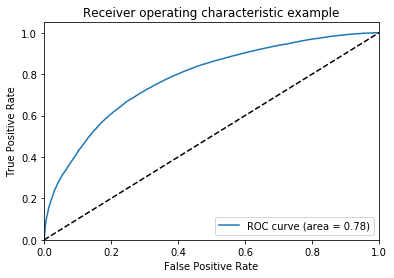

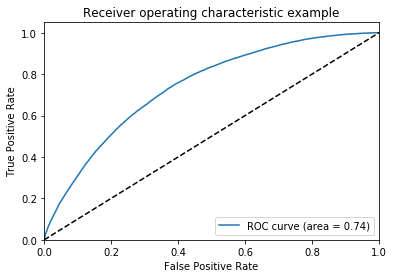

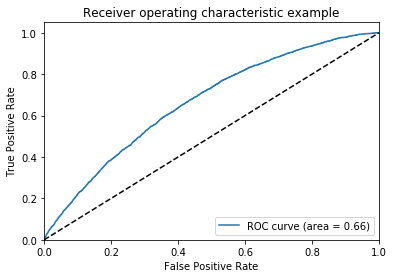

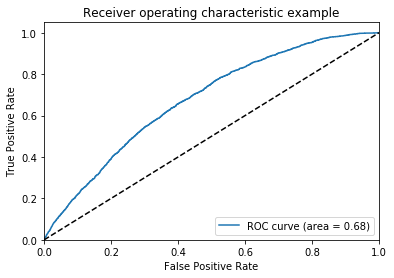

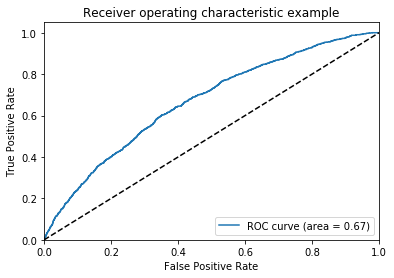

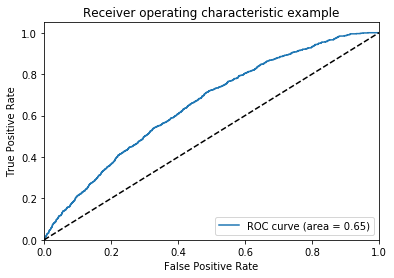

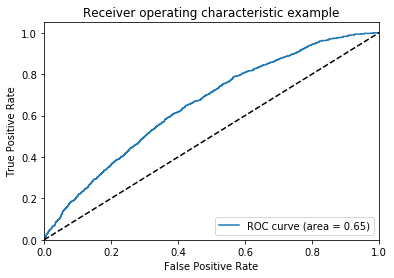

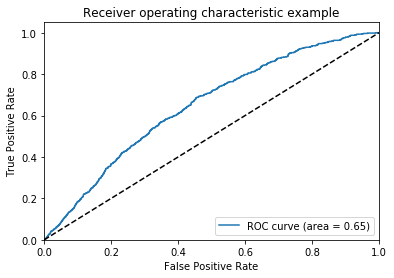

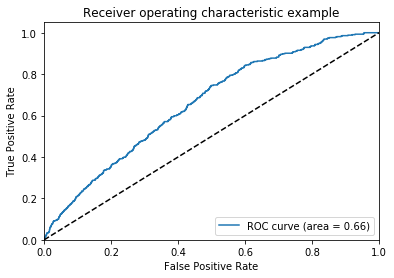

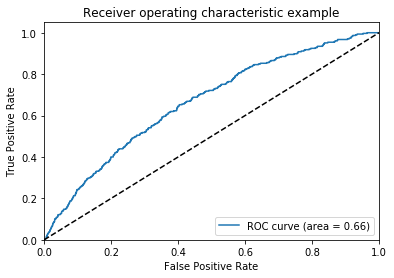

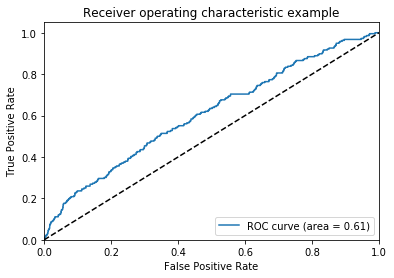

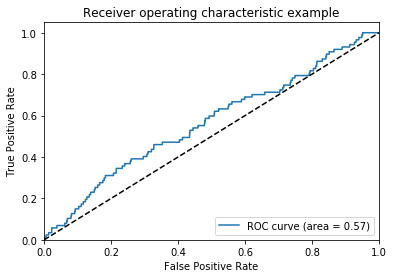

In [44]:
### Plotting the ROC curves
import matplotlib.pyplot as plt
for i in range(12):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


The target categories are very unbalanced, in fact almost the 87% of costumer decided not to travel at all "NDF" or decided to travel to "US", while only the 0.1% decided to travel to "PT".
This bring to two problems.
    - as seen above, the capacity of prediction, decrease the more the class is unbalacend, infact it pass from 0.78 for the predictor of "NDF" to 0.56 for the predictor of "PT".
    - if we want to use the score obtained from the model to predict the exact country destination we need to scale them, otherwise we will predict only the most frequest classes. (but doing that we risk to overestimate the less frequent classes)

In [45]:
y_valid.value_counts(normalize=True) * 100

0     58.346705
1     29.221958
2      4.729389
3      2.352983
4      1.328164
5      1.089235
6      1.054099
7      0.668767
8      0.496598
9      0.357222
10     0.252984
11     0.101896
Name: TARGET, dtype: float64

In [46]:
### Check the Predictions with non scaled score
pred_valid=pd.DataFrame(pred_valid)
pred_valid['target'] = actual_valid.reset_index()['TARGET']
pred_valid['predicted_target'] = pred_valid[[x for x in pred_valid.columns if ('target' not in str(x).lower()) & (str(x).lower() != 'wrong')]].idxmax(axis=1)
pred_valid['wrong']=0
pred_valid['wrong'][pred_valid['predicted_target']!=pred_valid['target']] = 1

#pred_valid_scaled.to_csv('C:\\Users\\11621842\\Desktop\\con_te\\pred_valid_scaled', header = True, sep=';')
#pred_valid_scaled = pd.read_csv('C:\\Users\\11621842\\Desktop\\con_te\\pred_valid_scaled', sep=';')        
#pred_valid_scaled = pred_valid_scaled.drop('Unnamed: 0', axis = 1)         
print("If we don't scale the scores we have {} rows wrong predicted over {}".format(str(np.sum(pred_valid['wrong'])), str(len(pred_valid))))
print("The percentage of wrong prediction is {}".format(str(np.sum(pred_valid[pred_valid['predicted_target']>=0]['wrong'])/len(pred_valid[pred_valid['predicted_target']>=0]))))


If we don't scale the scores we have 29934 rows wrong predicted over 85381
The percentage of wrong prediction is 0.350593223316663


In [47]:
### Check the Predictions with scaled score
from sklearn import preprocessing

pred_valid=pd.DataFrame(pred_valid)
x = pred_valid[[x for x in pred_valid.columns if ('target' not in str(x).lower()) & (str(x).lower() != 'wrong')]].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
x_scaled = min_max_scaler.fit_transform(x)

pred_valid_scaled=pd.DataFrame(x_scaled)
pred_valid_scaled.columns=[x for x in pred_valid.columns if ('target' not in str(x).lower()) & (str(x).lower() != 'wrong')]
pred_valid_scaled['target'] = actual_valid.reset_index()['TARGET']

pred_valid_scaled['predicted_target'] = pred_valid_scaled[[x for x in pred_valid_scaled.columns if ('target' not in str(x).lower()) & (str(x).lower() != 'wrong')]].idxmax(axis=1)
pred_valid_scaled['wrong']=0
pred_valid_scaled['wrong'][pred_valid_scaled['predicted_target']!=pred_valid_scaled['target']] = 1

#pred_valid_scaled.to_csv('C:\\Users\\11621842\\Desktop\\con_te\\pred_valid_scaled', header = True, sep=';')
#pred_valid_scaled = pd.read_csv('C:\\Users\\11621842\\Desktop\\con_te\\pred_valid_scaled', sep=';')        
#pred_valid_scaled = pred_valid_scaled.drop('Unnamed: 0', axis = 1)         
print("If we scale the scores we have {} rows wrong predicted over {}".format(str(np.sum(pred_valid_scaled['wrong'])), str(len(pred_valid_scaled))))
print("The percentage of wrong prediction is {}".format(str(np.sum(pred_valid_scaled[pred_valid_scaled['predicted_target']>=0]['wrong'])/len(pred_valid_scaled[pred_valid_scaled['predicted_target']>=0]))))


If we scale the scores we have 30144 rows wrong predicted over 85381
The percentage of wrong prediction is 0.3530527869198065


   ### Features Importance
  

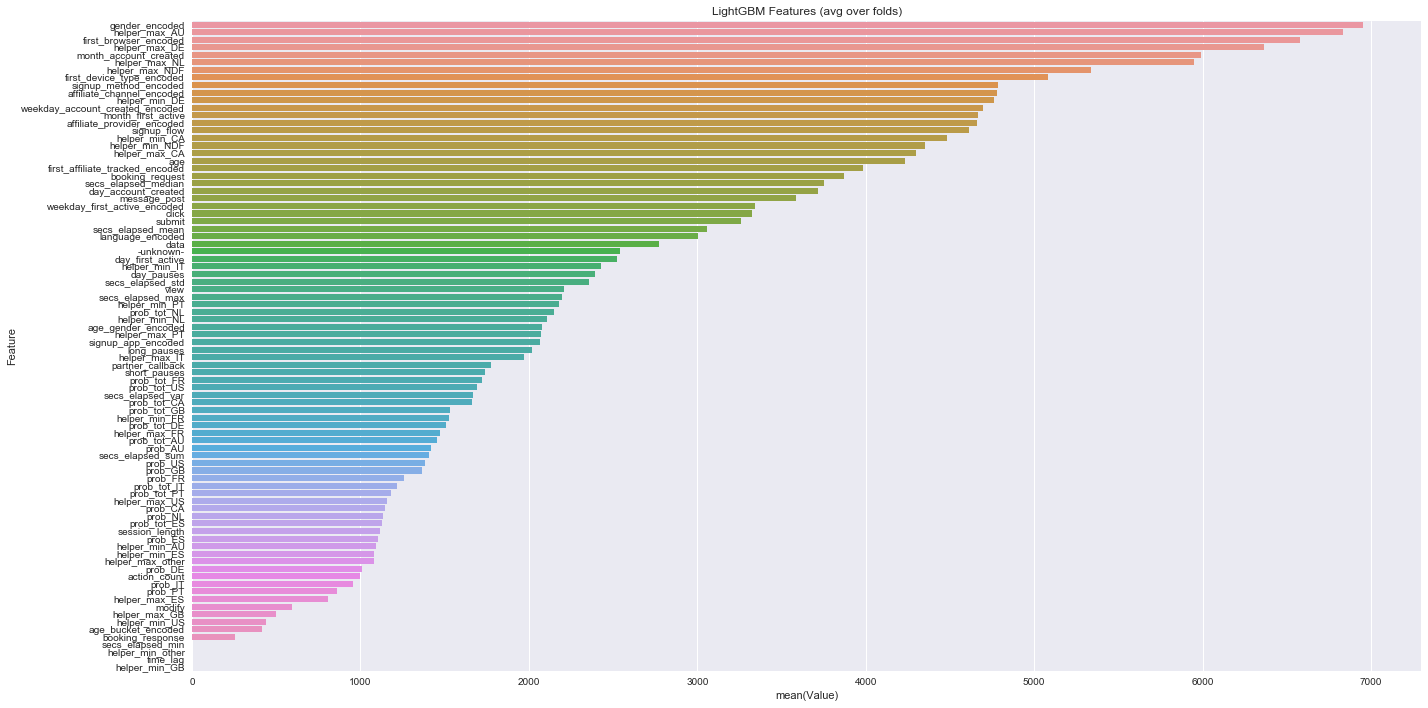

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(lgbmodel.feature_importance(),X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

From Features importance we can see that the most important variable (according to the model) is Gender, one of the "helper" variable is the second, the Browser is the third, and the month when the account was created is the fifth.

Then we can notice that in the first half of the most important features (not considering the helper variables) there are anagrafical variables (such as Age, Gender) and sessions variables.

This makes us understand that, to predict the first destination country is very important to know very well the customers, collecting the highest number of information about him/her, and about what he/she does on the website. 
Also, of course, the problem is influenced by seasonality, so knowning when the account is created is very important (we may assume that the date of the creation of the account will usually be near to the booking date).

Below the plot of frequencies of Gender, first Browser and the month of the creation of the account by country destination.

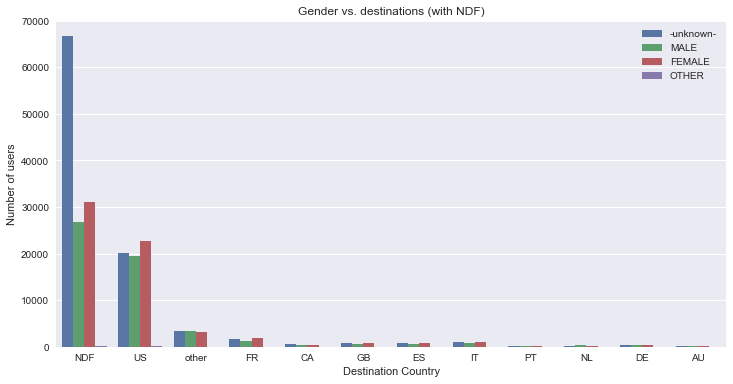

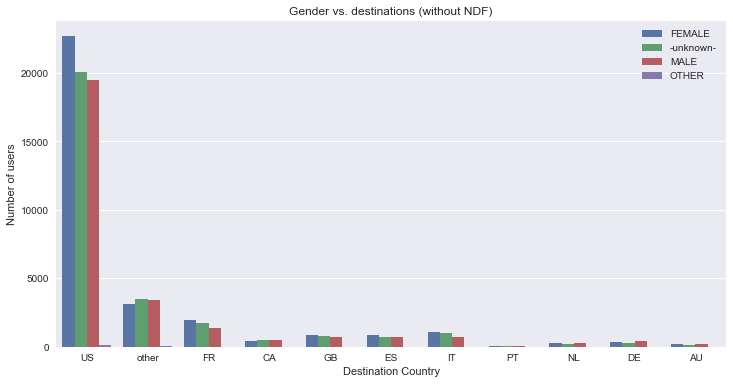

In [49]:
plt.figure(figsize=(12,6))
sns.countplot(x='country_destination', data = train, hue = 'gender')
plt.xlabel('Destination Country')
plt.ylabel('Number of users')
plt.title('Gender vs. destinations (with NDF)')
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(12,6))
sns.countplot(x='country_destination', data = train[train['country_destination']!='NDF'], hue = 'gender')
plt.xlabel('Destination Country')
plt.ylabel('Number of users')
plt.title('Gender vs. destinations (without NDF)')
plt.legend(loc='upper right')
plt.show()

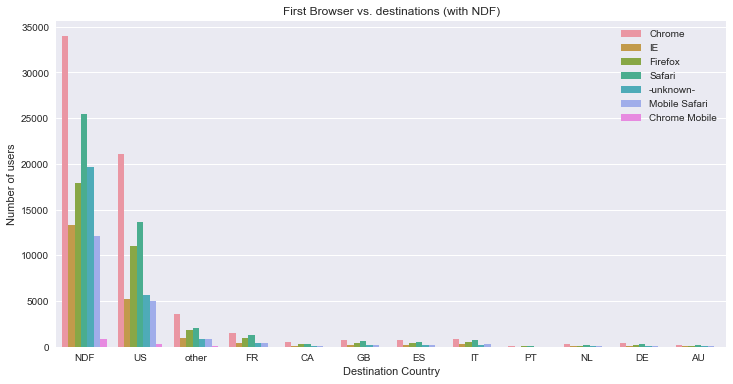

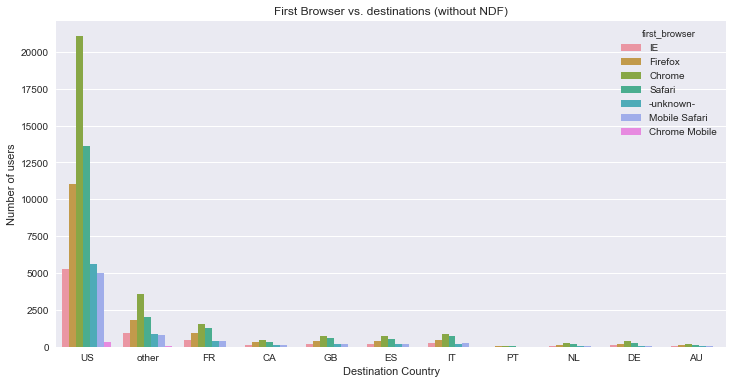

In [50]:
most_frq_browsers=train.first_browser.value_counts()[:7].index.tolist()

plt.figure(figsize=(12,6))
sns.countplot(x='country_destination', data = train[train['first_browser'].isin(most_frq_browsers)], hue = 'first_browser')
plt.xlabel('Destination Country')
plt.ylabel('Number of users')
plt.title('First Browser vs. destinations (with NDF)')
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(12,6))
sns.countplot(x='country_destination', data = train[(train['first_browser'].isin(most_frq_browsers)) & (train['country_destination']!='NDF')], hue = 'first_browser')
plt.xlabel('Destination Country')
plt.ylabel('Number of users')
plt.title('First Browser vs. destinations (without NDF)')
plt.show()

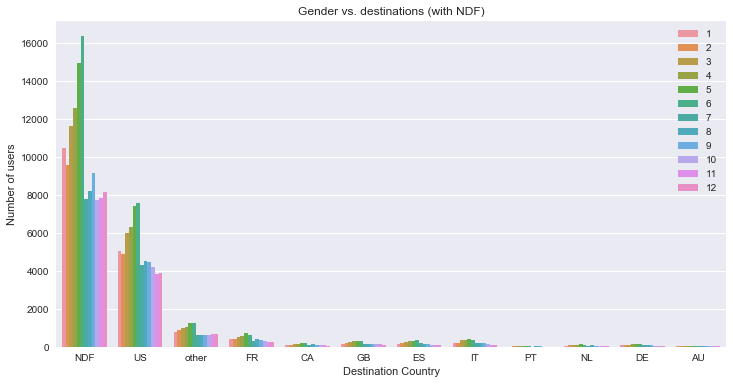

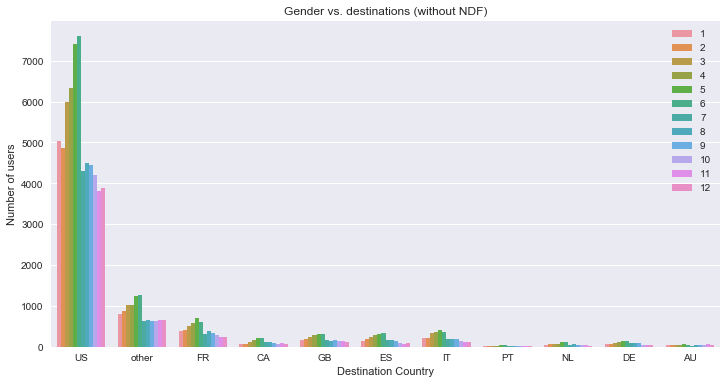

In [51]:
plt.figure(figsize=(12,6))
sns.countplot(x='country_destination', data = df_train, hue = 'month_account_created')
plt.xlabel('Destination Country')
plt.ylabel('Number of users')
plt.title('Gender vs. destinations (with NDF)')
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(12,6))
sns.countplot(x='country_destination', data = df_train[train['country_destination']!='NDF'], hue = 'month_account_created')
plt.xlabel('Destination Country')
plt.ylabel('Number of users')
plt.title('Gender vs. destinations (without NDF)')
plt.legend(loc='upper right')
plt.show()

   ### Make Prediction on Test Set

In [52]:
### prediction on Test

preds=pd.DataFrame(lgbmodel.predict(df_test[num_cols], num_iteration=lgbmodel.best_iteration))
x = preds[[x for x in preds.columns if 'target' not in str(x).lower()]].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

preds_scaled=pd.DataFrame(x_scaled)
preds_scaled.columns=[x for x in preds.columns if 'target' not in str(x).lower()]
preds_scaled['TARGET']=preds_scaled[[x for x in preds_scaled.columns if str(x).lower() != 'id']].idxmax(axis=1)
preds_scaled['id']=df_test['id'].reset_index(drop=True)
preds_scaled['country']='nnn'
for i in range(len(list(dic_target.values()))):
    preds_scaled['country'][preds_scaled['TARGET']==list(dic_target.values())[i]]=list(dic_target.keys())[i]

preds_final=preds_scaled[['id', 'country']]

preds_final.to_csv('C:\\Users\\11621842\\Desktop\\con_te\\predictions.csv', sep=',', header=True, index=False)



In [53]:
#check test prediction Frequencies
preds_scaled['country'].value_counts(normalize=True) * 100

NDF      73.644035
US       25.900219
other     0.161041
AU        0.048312
FR        0.046702
GB        0.043481
PT        0.043481
IT        0.028987
ES        0.028987
NL        0.027377
DE        0.022546
CA        0.004831
Name: country, dtype: float64

In [54]:
preds_final.head()

,id,country
0,5uwns89zht,NDF
1,jtl0dijy2j,NDF
2,xx0ulgorjt,NDF
3,6c6puo6ix0,NDF
4,czqhjk3yfe,US
